In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import skimage.io as skio
import torch.optim as optim
import skimage as sk
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data = np.load(f"lego_200x200.npz")
images_train = data["images_train"] / 255.0
c2ws_train = data["c2ws_train"]
images_val = data["images_val"] / 255.0
c2ws_val = data["c2ws_val"]
c2ws_test = data["c2ws_test"]
focal = data["focal"]

In [4]:
height = 200
width = 200
n_samples = 32

In [5]:
K = np.array([[focal,0,width/2],[0,focal,height/2],[0,0,1]])

In [6]:
def transform(c2w, x_c):
    #camera to world
    num_rows = len(x_c)
    ones_column = np.ones((num_rows, 1))
    x_c_with_one = np.concatenate((x_c, ones_column), axis=1)
    x = (c2w @ x_c_with_one.T).T
    return x[:,:-1]

In [7]:
def pixel_to_camera(K, uv,s):
    num_rows = len(uv)
    ones_column = np.ones((num_rows, 1))
    uv_with_one = np.concatenate((uv, ones_column), axis=1)
    result = (np.linalg.inv(K) @ uv_with_one.T).T
    return result

In [8]:
def pixel_to_ray(K, c2w, uv):
    zeros = np.array([[0,0,0]])
    origin = transform(c2w, zeros)
    depth_1_points = pixel_to_camera(K, uv, 1)
    world_depth_1_points = transform(c2w, depth_1_points)
    world_depth_1_points_direction = world_depth_1_points - origin
    norms = np.linalg.norm(world_depth_1_points_direction, axis=1, keepdims=True)
    directions = world_depth_1_points_direction/ norms

    return origin, directions

In [9]:
class RaysData(Dataset):
    def __init__(self, img_train, K, c2ws_train):
        self.img = img_train
        self.c2ws = c2ws_train
        self.K = K
        self.height = 200
        self.width = 200
        self.length = len(self.img) * self.height * self.width

    def __len__(self):
        return len(self.img) * self.height * self.width
    
    def __getitem__(self, idx):
        img_index = idx // (self.width*self.height)
        residual = idx % (self.width*self.height)
        temp_height = residual // self.height 
        temp_width = residual % self.width 
        c2w = self.c2ws[img_index]
        uv = np.array([[temp_height+0.5, temp_width+0.5]])
        ray_o, ray_d = pixel_to_ray(self.K, c2w, uv)
        pixel = self.img[img_index,temp_height,temp_width,:]
        sample = {'rays_o':ray_o[0],
                  "rays_d":ray_d[0],
                 "pixels":pixel}
        return sample

    def sample_rays(self, num_samples):
        rays_o = []
        rays_d = []
        pixels = []
        # random_numbers = [random.randint(0,self.length -1) for _ in range(num_samples)]
        random_numbers = np.random.randint(0, self.length - 1, size=num_samples) 
        for random_number in random_numbers:
            img_index = random_number // (self.width*self.height)
            residual = random_number % (self.width*self.height)
            temp_height = residual // self.height 
            temp_width = residual % self.width 
            c2w = self.c2ws[img_index]
            uv = np.array([[temp_height+0.5, temp_width+0.5]])
            ray_o, ray_d = pixel_to_ray(self.K, c2w, uv)
            rays_o.append(ray_o[0])
            rays_d.append(ray_d[0])
            pixels.append(self.img[img_index,temp_height,temp_width,:])
        return rays_o, rays_d,pixels

In [51]:
# aaa =   torch.ones(100, 32) * torch.rand(1)*(6 - 2 )/ n_samples 

In [52]:
# aaa

tensor([[0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
        [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
        [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
        ...,
        [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
        [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
        [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373]])

In [20]:
def sample_along_rays(rays_o, rays_d, n_samples=32, perturb=True):
    far = 6 
    near = 2
    
    t_values = torch.linspace(near, far, n_samples).to(device)
    # ran_values = (torch.rand((len(rays_o), n_samples)) * (far - near) / n_samples).to(device)
    ran_values = torch.ones(len(rays_o), n_samples) * torch.rand(1)*(far - near) / n_samples 
    ran_values = ran_values.to(device)
    # Create 3D grid for rays_o and rays_d
    ray_o_grid = rays_o[:, None, :].repeat(1, n_samples, 1)
    ray_d_grid = rays_d[:, None, :].repeat(1, n_samples, 1)

    # Compute points without explicit loops
    if perturb:
        p_t = t_values + ran_values
    else:
        p_t = t_values + ran_values*0
    p_t = p_t.to(device)
    points = ray_o_grid + ray_d_grid * p_t.unsqueeze(2)

    return points.view(-1, 3)

In [11]:
def volrend(sigmas, rgbs, step_size):
    sigmas = sigmas.to(device)
    rgbs = rgbs.to(device)
    size_to_prepend = (sigmas.size(0), 1, 1)

    zeros_to_prepend = torch.zeros(size_to_prepend, dtype=sigmas.dtype).to(device)
    
    tensor_with_zeros = torch.cat((zeros_to_prepend, sigmas), dim=1).to(device)

    
    
    cum_sigmas = torch.cumsum(tensor_with_zeros,dim=1)[:,:-1].to(device)
    T = torch.exp(-cum_sigmas*step_size).to(device)
    interval_sigmas = 1 - torch.exp(-sigmas*step_size).to(device)
    weights = T * interval_sigmas
    colors = rgbs * weights
    cum_colors = torch.sum(colors, dim=1).to(device)

    return cum_colors

In [12]:
class Residual_block(nn.Module):
    def __init__(self, dim):
        super(Residual_block, self).__init__()
        self.dim = dim
        self.linear_1 = nn.Linear(dim, dim)
        self.layer_norm_1 = nn.LayerNorm(normalized_shape=dim)
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(dim, dim)
        self.layer_norm_2 = nn.LayerNorm(normalized_shape=dim)
        nn.init.kaiming_normal_(self.linear_1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.linear_2.weight, mode='fan_in', nonlinearity='relu')

    def forward(self,x):
        origin_x = x
        x = self.linear_1(x)
        x = self.layer_norm_1(x)
        x = self.relu(x)
        x = self.linear_2(x)
        x = self.layer_norm_2(x)
        x = self.relu(x + origin_x)
        return x

In [13]:
class Nerf_model(nn.Module):
    def __init__(self,high_fre_level, high_fre_level_angle, hidden_dim):
        super(Nerf_model, self).__init__()
        self.high_fre_level = high_fre_level
        self.high_fre_level_angle = high_fre_level_angle
        self.pe_dim = 3+high_fre_level*6
        self.pe_dim_angle = 3 + 6 * high_fre_level_angle
        self.input_layer = nn.Linear(3+high_fre_level*6, hidden_dim)
        self.residual_block_1 = Residual_block(hidden_dim)
        self.residual_block_2 = Residual_block(hidden_dim)
        self.residual_block_3 = Residual_block(hidden_dim)
        
        self.hidden_layer_1 = nn.Linear(hidden_dim, hidden_dim)
        self.hidden_layer_2 = nn.Linear(hidden_dim, hidden_dim)
        
        self.hidden_layer_concat_angle = nn.Linear(hidden_dim + self.pe_dim_angle, hidden_dim//2)

        nn.init.kaiming_normal_(self.hidden_layer_concat_angle.weight, mode='fan_in', nonlinearity='relu')
        
        self.out = nn.Linear(hidden_dim//2, 3)
        nn.init.kaiming_normal_(self.out.weight, mode='fan_in', nonlinearity='relu')
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.density_layer = nn.Linear(hidden_dim, 1)

        power_terms_pos = (torch.exp2(torch.arange(0, high_fre_level))*3.14159).to(device)
        
        power_terms_angle = (torch.exp2(torch.arange(0, high_fre_level_angle))*3.14159).to(device)
        
        self.power_matrix_pos= torch.zeros(3, self.high_fre_level *3).to(device)
        for i in range(3):
            self.power_matrix_pos[i,i*high_fre_level:(i+1)*high_fre_level] = power_terms_pos

        self.power_matrix_angle = torch.zeros(3, self.high_fre_level_angle  *3).to(device)
        for i in range(3):
            self.power_matrix_angle[i,i*high_fre_level_angle :(i+1)*high_fre_level_angle ] = power_terms_angle


        self.middle_layer_norm = nn.LayerNorm(normalized_shape=hidden_dim) 
        
        self.last_layer_norm = nn.LayerNorm(normalized_shape=hidden_dim//2) 

    def positional_encoding(self, data, high_fre_level, power_matrix):

        powered_data = data @ power_matrix
        sin_matrix = torch.sin(powered_data).to(device)
        cos_matrix = torch.cos(powered_data).to(device)

        pe = torch.cat((data, sin_matrix, cos_matrix),1).to(device)

        return pe

    def forward(self,pos, angle):
                
        pos_pe = self.positional_encoding(pos, self.high_fre_level, self.power_matrix_pos)
        
        origin_x = pos_pe
        x = self.input_layer(origin_x)
        x = self.residual_block_1(x)
        x = self.residual_block_2(x)
        x = self.residual_block_3(x)
        x = self.hidden_layer_1(x)
        sigmas = self.density_layer(x)
        sigmas = self.relu(sigmas)

        # x = self.middle_layer_norm(x)
        x = self.hidden_layer_2(x)

        angle_pe = self.positional_encoding(angle, self.high_fre_level_angle, self.power_matrix_angle)
        # angle_input = torch.cat((angle,angle_pe),dim=1)
        concated_x = torch.cat((x,angle_pe), dim = 1).float()
        x = self.hidden_layer_concat_angle(concated_x)
        x = self.last_layer_norm(x)
        x = self.relu(x)
        x = self.out(x)
        x = self.sigmoid(x)
        return x, sigmas

In [14]:
# class Nerf_model(nn.Module):
#     def __init__(self,high_fre_level, high_fre_level_angle, hidden_dim):
#         super(Nerf_model, self).__init__()
#         self.high_fre_level = high_fre_level
#         self.high_fre_level_angle = high_fre_level_angle
#         self.pe_dim = 3+high_fre_level*6
#         self.pe_dim_angle = 3 + 6 * high_fre_level_angle
#         self.input_layer = nn.Linear(3+high_fre_level*6, hidden_dim)
#         # self.input_layer = nn.Linear(2, hidden_dim)
#         hidden_layer_list = []


        
#         for i in range(3):
#             hidden_layer_list.append(nn.Linear(hidden_dim, hidden_dim))
#             hidden_layer_list.append(nn.ReLU())
#         self.hidden_layer_1 = nn.Sequential(*hidden_layer_list)

#         self.concat_hidden_layer = nn.Linear(hidden_dim + self.pe_dim,hidden_dim)
        
#         hidden_layer_list = []
#         for i in range(2):
#             hidden_layer_list.append(nn.Linear(hidden_dim, hidden_dim))
#             hidden_layer_list.append(nn.ReLU())
#         self.hidden_layer_2 = nn.Sequential(*hidden_layer_list)

#         self.hidden_layer_3 = nn.Linear(hidden_dim, hidden_dim)
#         self.hidden_layer_4 = nn.Linear(hidden_dim, hidden_dim)
#         self.hidden_layer_5 = nn.Linear(hidden_dim, hidden_dim)
#         self.hidden_layer_concat_angle = nn.Linear(hidden_dim + self.pe_dim_angle, hidden_dim//2)

#         self.out = nn.Linear(hidden_dim//2, 3)
#         self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()
#         self.density_layer = nn.Linear(hidden_dim, 1)
        
#         power_terms_pos = (torch.exp2(torch.arange(0, high_fre_level))*3.14159).to(device)
        
#         power_terms_angle = (torch.exp2(torch.arange(0, high_fre_level_angle))*3.14159).to(device)
        
#         self.power_matrix_pos= torch.zeros(3, self.high_fre_level *3).to(device)
#         for i in range(3):
#             self.power_matrix_pos[i,i*high_fre_level:(i+1)*high_fre_level] = power_terms_pos

#         self.power_matrix_angle = torch.zeros(3, self.high_fre_level_angle  *3).to(device)
#         for i in range(3):
#             self.power_matrix_angle[i,i*high_fre_level_angle :(i+1)*high_fre_level_angle ] = power_terms_angle

#         # self.layer_norm1 = nn.LayerNorm(normalized_shape=HIDDEN_UNITS)  
#         # self._initialize_weights()
#         self.last_layer_norm = nn.LayerNorm(normalized_shape=hidden_dim//2) 
        

#     def _initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
#                 if m.bias is not None:
#                     nn.init.zeros_(m.bias)


    


#     def positional_encoding(self, data, high_fre_level, power_matrix):

#         powered_data = data @ power_matrix
#         sin_matrix = torch.sin(powered_data).to(device)
#         cos_matrix = torch.cos(powered_data).to(device)

#         pe = torch.cat((data, sin_matrix, cos_matrix),1).to(device)

#         return pe




    
#     def forward_phase_1(self, origin_x):

#         x = self.input_layer(origin_x)
#         x = self.relu(x)
#         x = self.hidden_layer_1(x)
#         x = torch.cat((x,origin_x), dim = 1)
#         x = self.concat_hidden_layer(x)
#         x = self.relu(x)
#         x = self.hidden_layer_2(x)
#         x = self.hidden_layer_3(x)
#         return x


        
#     def forward(self, pos, angle):
        
#         pos_pe = self.positional_encoding(pos, self.high_fre_level, self.power_matrix_pos)
        
#         origin_x = pos_pe
#         x = self.forward_phase_1(origin_x)




        
#         sigmas = self.density_layer(x)
#         sigmas = self.relu(sigmas)
        
#         x = self.hidden_layer_4(x)
#         angle_pe = self.positional_encoding(angle, self.high_fre_level_angle, self.power_matrix_angle)
#         # angle_input = torch.cat((angle,angle_pe),dim=1)
#         concated_x = torch.cat((x,angle_pe), dim = 1).float()
#         x = self.hidden_layer_concat_angle(concated_x)
#         x = self.last_layer_norm(x)
#         x = self.relu(x)
#         x = self.out(x)
#         x = self.sigmoid(x)
#         return x, sigmas
        

In [60]:
def calcualte_PSNR():
    model.eval()
    loss_fn = nn.SmoothL1Loss(reduction='sum')
    dataset = RaysData(images_val, K, c2ws_val)
    dataloader = DataLoader(dataset, batch_size=10000,
                        shuffle=True)
    loss = 0
    for i_batch, sample_batched in enumerate(tqdm(dataloader)):
        # print(len(sample_batched['pixels']))
        # rays_o, rays_d, pixels = dataset.sample_rays(10000)
        # rays_o, rays_d, pixels = dataset.sample_rays_one(1000)
        # t1 = time.time()
        rays_o = sample_batched['rays_o'].squeeze()
        rays_d = sample_batched['rays_d'].squeeze()
        pixels = sample_batched['pixels']
        rays_o = rays_o.float().to(device)
        rays_d = rays_d.float().to(device)
        # rays_d = np.array(rays_d)
        # rays_o = np.array(rays_o)
        # rays_d = torch.tensor(rays_d).to(device)
        # rays_o = torch.tensor(rays_o).to(device)
        points = sample_along_rays(rays_o, rays_d)
        
    
        points = points.float().to(device)
        # points = np.array(points)
        # rays_d = np.array(rays_d)
        # points = torch.tensor(points).to(device)
        # rays_d = torch.tensor(rays_d).to(device)
    
        rays_d = torch.unsqueeze(rays_d,1)
        rays_d = rays_d.repeat(1,n_samples,1)
        rays_d = rays_d.view(-1,3)
        
        # t2 = time.time()
        # print('p',t2-t1)
        # t1 = t2
        
        rgbs, sigmas = model(points, rays_d)
        
        # t2 = time.time()
        # print('forward',t2-t1)
        # t1 = t2
        
        rgbs = rgbs.to(device)
        sigmas = sigmas.to(device)
        # sigams = model.foward_dentisy()
        sigmas = sigmas.view(-1, n_samples, 1)
        rgbs = rgbs.view(-1, n_samples, 3)
        
    
    
        rendered_colors = volrend(sigmas, rgbs, step_size)

                
        # t2 = time.time()
        # print('render',t2-t1)
        # t1 = t2
        # print("render",rendered_colors[0])
        # print("pixels",pixels[0])
    
        pixels = pixels.float().to(device)

        with torch.no_grad():
            loss += loss_fn(rendered_colors, pixels)
    return loss.item()/len(dataset)

In [14]:
model = Nerf_model(30,10,256).to(device)
step_size = (6-2)/n_samples

In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

2023-11-05 20:42:03.235729: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-05 20:42:03.804867: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [61]:
PSNR_loss_list = []

global_iter = 0

In [ ]:
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# criterion = PSNRWithMSELoss()
criterion = torch.nn.MSELoss()
number_epoch  = 10
model.train()
# scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
# for i in range(number_iteration):

dataset = RaysData(images_train, K, c2ws_train)
dataloader = DataLoader(dataset, batch_size=10000,
                        shuffle=True)

for e in range(number_epoch):
    for i_batch, sample_batched in enumerate(tqdm(dataloader)):
        # print(len(sample_batched['pixels']))
        # rays_o, rays_d, pixels = dataset.sample_rays(10000)
        # rays_o, rays_d, pixels = dataset.sample_rays_one(1000)
        # t1 = time.time()
        rays_o = sample_batched['rays_o'].squeeze()
        rays_d = sample_batched['rays_d'].squeeze()
        pixels = sample_batched['pixels']
        rays_o = rays_o.float().to(device)
        rays_d = rays_d.float().to(device)
        # rays_d = np.array(rays_d)
        # rays_o = np.array(rays_o)
        # rays_d = torch.tensor(rays_d).to(device)
        # rays_o = torch.tensor(rays_o).to(device)
        points = sample_along_rays(rays_o, rays_d)
        
    
        points = points.float().to(device)
        # points = np.array(points)
        # rays_d = np.array(rays_d)
        # points = torch.tensor(points).to(device)
        # rays_d = torch.tensor(rays_d).to(device)
    
        rays_d = torch.unsqueeze(rays_d,1)
        rays_d = rays_d.repeat(1,n_samples,1)
        rays_d = rays_d.view(-1,3)
        
        # t2 = time.time()
        # print('p',t2-t1)
        # t1 = t2
        
        rgbs, sigmas = model(points, rays_d)
        
        # t2 = time.time()
        # print('forward',t2-t1)
        # t1 = t2
        
        rgbs = rgbs.to(device)
        sigmas = sigmas.to(device)
        # sigams = model.foward_dentisy()
        sigmas = sigmas.view(-1, n_samples, 1)
        rgbs = rgbs.view(-1, n_samples, 3)
        
    
    
        rendered_colors = volrend(sigmas, rgbs, step_size)

                
        # t2 = time.time()
        # print('render',t2-t1)
        # t1 = t2
        # print("render",rendered_colors[0])
        # print("pixels",pixels[0])
    
        pixels = pixels.float().to(device)
        # pixels = np.array(pixels)
        # pixels = torch.tensor(pixels).float().to(device)
    
        # print(rendered_colors)
        loss = criterion(rendered_colors, pixels)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

                        
        # t2 = time.time()
        # print('backward',t2-t1)
        # t1 = t2
        # scheduler.step()
        # if global_iter % 100 ==0:
        #     PSNR_loss_list.append(calcualte_PSNR())
        #     print(PSNR_loss_list[-1])
        global_iter += 1
        if i_batch % 49 == 0:
            print(f'iteration [{i_batch}], Loss: {loss.item()}')
    # scheduler.step()
    # torch.save(model.state_dict(), 'weights_%s.pth'%e)

  0%|                                           | 1/400 [00:00<04:43,  1.41it/s]

iteration [0], Loss: 0.009118574671447277


 12%|█████▎                                    | 50/400 [00:24<03:01,  1.93it/s]

iteration [49], Loss: 0.009159006178379059


 25%|██████████▍                               | 99/400 [00:48<02:58,  1.68it/s]

iteration [98], Loss: 0.00911837536841631


 37%|███████████████▏                         | 148/400 [01:13<02:33,  1.64it/s]

iteration [147], Loss: 0.009062281809747219


 49%|████████████████████▏                    | 197/400 [01:37<01:55,  1.75it/s]

iteration [196], Loss: 0.009737125597894192


 62%|█████████████████████████▏               | 246/400 [02:01<01:20,  1.91it/s]

iteration [245], Loss: 0.009025134146213531


 74%|██████████████████████████████▏          | 295/400 [02:24<00:55,  1.89it/s]

iteration [294], Loss: 0.009039823897182941


 86%|███████████████████████████████████▎     | 344/400 [02:47<00:30,  1.81it/s]

iteration [343], Loss: 0.008624709211289883


 98%|████████████████████████████████████████▎| 393/400 [03:11<00:03,  1.89it/s]

iteration [392], Loss: 0.00950885470956564


  0%|                                           | 1/400 [00:00<04:42,  1.41it/s]

iteration [0], Loss: 0.009429709985852242


 12%|█████▎                                    | 50/400 [00:25<03:21,  1.73it/s]

iteration [49], Loss: 0.00890385266393423


 25%|██████████▍                               | 99/400 [00:50<02:55,  1.71it/s]

iteration [98], Loss: 0.009535830467939377


 37%|███████████████▏                         | 148/400 [01:14<02:06,  1.99it/s]

iteration [147], Loss: 0.009575595147907734


 49%|████████████████████▏                    | 197/400 [01:37<01:43,  1.96it/s]

iteration [196], Loss: 0.008651482872664928


 62%|█████████████████████████▏               | 246/400 [02:00<01:19,  1.93it/s]

iteration [245], Loss: 0.009531915187835693


 74%|██████████████████████████████▏          | 295/400 [02:23<00:57,  1.82it/s]

iteration [294], Loss: 0.00903325341641903


 86%|███████████████████████████████████▎     | 344/400 [02:46<00:28,  1.98it/s]

iteration [343], Loss: 0.00862707756459713


 98%|████████████████████████████████████████▎| 393/400 [03:09<00:03,  1.87it/s]

iteration [392], Loss: 0.009405022487044334


  0%|                                           | 1/400 [00:00<04:40,  1.42it/s]

iteration [0], Loss: 0.009073156863451004


 12%|█████▎                                    | 50/400 [00:23<03:05,  1.88it/s]

iteration [49], Loss: 0.008554104715585709


 25%|██████████▍                               | 99/400 [00:46<02:33,  1.96it/s]

iteration [98], Loss: 0.009116125293076038


 37%|███████████████▏                         | 148/400 [01:10<02:17,  1.84it/s]

iteration [147], Loss: 0.008890364319086075


 49%|████████████████████▏                    | 197/400 [01:34<01:53,  1.79it/s]

iteration [196], Loss: 0.00894189067184925


 62%|█████████████████████████▏               | 246/400 [01:59<01:25,  1.80it/s]

iteration [245], Loss: 0.008941726759076118


 74%|██████████████████████████████▏          | 295/400 [02:22<00:57,  1.83it/s]

iteration [294], Loss: 0.008191089145839214


 86%|███████████████████████████████████▎     | 344/400 [02:46<00:29,  1.88it/s]

iteration [343], Loss: 0.009294500574469566


 98%|████████████████████████████████████████▎| 393/400 [03:10<00:03,  1.82it/s]

iteration [392], Loss: 0.008945686742663383


  0%|                                           | 1/400 [00:00<04:46,  1.39it/s]

iteration [0], Loss: 0.00890262145549059


 12%|█████▎                                    | 50/400 [00:25<03:06,  1.87it/s]

iteration [49], Loss: 0.008393248543143272


 25%|██████████▍                               | 99/400 [00:49<02:42,  1.85it/s]

iteration [98], Loss: 0.008893245831131935


 37%|███████████████▏                         | 148/400 [01:12<02:10,  1.93it/s]

iteration [147], Loss: 0.008087498135864735


 49%|████████████████████▏                    | 197/400 [01:35<01:54,  1.77it/s]

iteration [196], Loss: 0.008676276542246342


 62%|█████████████████████████▏               | 246/400 [02:00<01:24,  1.83it/s]

iteration [245], Loss: 0.008605734445154667


 74%|██████████████████████████████▏          | 295/400 [02:24<00:57,  1.84it/s]

iteration [294], Loss: 0.008569472469389439


 86%|███████████████████████████████████▎     | 344/400 [02:49<00:31,  1.80it/s]

iteration [343], Loss: 0.008912510238587856


 98%|████████████████████████████████████████▎| 393/400 [03:13<00:03,  1.90it/s]

iteration [392], Loss: 0.008327541872859001


  0%|                                           | 1/400 [00:00<04:46,  1.39it/s]

iteration [0], Loss: 0.00916254986077547


 12%|█████▎                                    | 50/400 [00:24<03:06,  1.88it/s]

iteration [49], Loss: 0.008274149149656296


 25%|██████████▍                               | 99/400 [00:47<02:35,  1.93it/s]

iteration [98], Loss: 0.008355926722288132


 37%|███████████████▏                         | 148/400 [01:10<02:16,  1.85it/s]

iteration [147], Loss: 0.008391061797738075


 49%|████████████████████▏                    | 197/400 [01:33<01:48,  1.87it/s]

iteration [196], Loss: 0.008366436697542667


 62%|█████████████████████████▏               | 246/400 [01:58<01:22,  1.87it/s]

iteration [245], Loss: 0.00886088702827692


 74%|██████████████████████████████▏          | 295/400 [02:21<00:55,  1.89it/s]

iteration [294], Loss: 0.008525394834578037


 86%|███████████████████████████████████▎     | 344/400 [02:46<00:33,  1.70it/s]

iteration [343], Loss: 0.009186694398522377


 98%|████████████████████████████████████████▎| 393/400 [03:10<00:03,  1.87it/s]

iteration [392], Loss: 0.00823175348341465


  0%|                                           | 1/400 [00:00<04:45,  1.40it/s]

iteration [0], Loss: 0.008434439077973366


 12%|█████▎                                    | 50/400 [00:24<03:09,  1.85it/s]

iteration [49], Loss: 0.008196213282644749


 25%|██████████▍                               | 99/400 [00:48<02:50,  1.77it/s]

iteration [98], Loss: 0.00831760372966528


 37%|███████████████▏                         | 148/400 [01:11<02:08,  1.97it/s]

iteration [147], Loss: 0.008056072518229485


 49%|████████████████████▏                    | 197/400 [01:34<01:48,  1.88it/s]

iteration [196], Loss: 0.008315141312777996


 62%|█████████████████████████▏               | 246/400 [01:58<01:23,  1.85it/s]

iteration [245], Loss: 0.008244406431913376


 74%|██████████████████████████████▏          | 295/400 [02:22<00:55,  1.88it/s]

iteration [294], Loss: 0.008443151600658894


 86%|███████████████████████████████████▎     | 344/400 [02:46<00:30,  1.82it/s]

iteration [343], Loss: 0.008271190337836742


 98%|████████████████████████████████████████▎| 393/400 [03:11<00:03,  1.82it/s]

iteration [392], Loss: 0.008266865275800228


  0%|                                           | 1/400 [00:00<04:47,  1.39it/s]

iteration [0], Loss: 0.008439462631940842


 12%|█████▎                                    | 50/400 [00:24<02:59,  1.95it/s]

iteration [49], Loss: 0.008168701082468033


 25%|██████████▍                               | 99/400 [00:47<02:36,  1.92it/s]

iteration [98], Loss: 0.00789731740951538


 28%|███████████▍                             | 112/400 [00:53<02:16,  2.10it/s]

In [26]:
torch.save(model.state_dict(), 'weights_arc2.pth')

In [18]:
weights_path = 'weights_arc2.pth'  # Provide the correct path to the saved weights file
model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [ ]:
400: 1200 = 0.1287

In [24]:
model.eval()
eval_height = 200
eval_width = 200
c2w_eval = c2ws_train[1]
# c2w_eval = c2ws_test[0]
results = np.zeros((eval_height, eval_width,3))
for i in range(eval_height):
    uv = []
    for j in range(eval_width):
        uv.append([i+0.5,j+0.5])
    ray_o, ray_d = pixel_to_ray(K, c2w_eval, uv)
    rays_o = np.repeat(ray_o, eval_height, axis=0)
    rays_d = list(ray_d)

    rays_o = torch.tensor(rays_o).float().to(device)
    rays_d = torch.tensor(rays_d).float().to(device)
    points = sample_along_rays(rays_o, rays_d, perturb=False)
    points = points.to(device)
    # rays_d = torch.tensor(rays_d).to(device)
    rays_d = torch.unsqueeze(rays_d,1)
    rays_d = rays_d.repeat(1,n_samples,1)
    rays_d = rays_d.view(-1,3)
    
    rgbs, sigmas = model(points, rays_d)
    rgbs = rgbs.to(device)
    sigmas = sigmas.to(device)
    # sigams = model.foward_dentisy()
    sigmas = sigmas.view(-1, n_samples, 1)
    rgbs = rgbs.view(-1, n_samples, 3)
    
    rendered_colors = volrend(sigmas, rgbs, step_size).detach().cpu().numpy()

    # print(rendered_colors.shape)
    results[i,:,:] = rendered_colors

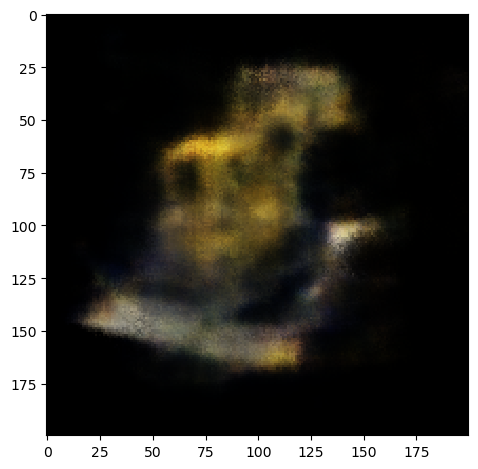

In [25]:

skio.imshow(results)
# skio.imsave("r_5000.jpg",results)

In [25]:
for index in range(len(c2ws_test)):
    print("saving: ", index)
    model.eval()
    eval_height = 200
    eval_width = 200
    # c2w_eval = c2ws_train[2]
    c2w_eval = c2ws_test[index]
    results = np.zeros((eval_height, eval_width,3))
    for i in range(eval_height):
        uv = []
        for j in range(eval_width):
            uv.append([i,j])
        ray_o, ray_d = pixel_to_ray(K, c2w_eval, uv)
        rays_o = np.repeat(ray_o, eval_height, axis=0)
        rays_d = list(ray_d)
    
        rays_o = torch.tensor(rays_o).float().to(device)
        rays_d = torch.tensor(rays_d).float().to(device)
        points = sample_along_rays(rays_o, rays_d)
        points = points.to(device)
        # rays_d = torch.tensor(rays_d).to(device)
        rays_d = torch.unsqueeze(rays_d,1)
        rays_d = rays_d.repeat(1,n_samples,1)
        rays_d = rays_d.view(-1,3)
        
        rgbs, sigmas = model(points, rays_d)
        rgbs = rgbs.to(device)
        sigmas = sigmas.to(device)
        # sigams = model.foward_dentisy()
        sigmas = sigmas.view(-1, n_samples, 1)
        rgbs = rgbs.view(-1, n_samples, 3)
        
        rendered_colors = volrend(sigmas, rgbs, step_size).detach().cpu().numpy()
    
        # print(rendered_colors.shape)
        results[i,:,:] = rendered_colors
    save_file_path = 'test_results/%s.png'%index  # Change the file extension as needed (e.g., .jpg, .png, .bmp, etc.)

    # Save the NumPy array as an image using skimage
    skio.imsave(save_file_path, results)

saving:  0


/tmp/ipykernel_64658/3453426374.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  rays_d = torch.tensor(rays_d).float().to(device)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  1


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  2


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  3


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  4


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  5


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  6


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  7


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  8


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  9


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  10


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  11


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  12


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  13


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  14


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  15


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  16


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  17


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  18


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  19


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  20


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  21


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  22


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  23


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  24


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  25


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  26


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  27


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  28


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  29


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  30


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  31


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  32


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  33


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  34


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  35


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  36


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  37


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  38


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  39


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  40


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  41


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  42


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  43


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  44


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  45


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  46


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  47


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  48


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  49


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  50


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  51


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  52


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  53


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  54


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  55


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  56


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  57


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  58


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


saving:  59


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
